## Sentiment analysis with Random Forest

**Importing libraries**

In [ ]:
import re
import string   
from wordcloud import WordCloud
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk import pos_tag, ne_chunk
from nltk.chunk import tree2conlltags

import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

import warnings
warnings.filterwarnings("ignore")

import time

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


**Import Dataset**

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# data_source_url = "/content/drive/MyDrive/TP_BDM/data.csv"
data_source_url = "/content/sample_data/data.csv"
df = pd.read_csv(data_source_url)

In [ ]:
# data_source_url = "/content/drive/MyDrive/TP_BDM/data.csv"
data_source_url = "https://drive.google.com/file/d/1NI1zdV8AK--SnSVFBsewrlzOuDK7oxo9/view?usp=sharing"
df = pd.read_csv(data_source_url)

**Understanding the dataset**

Our dataset is a table with 2 columns, where the 1st column contain the sentence and the 2nd one represent type of sentiment { positive , negative , neutral }

In [ ]:
df.head

<bound method NDFrame.head of                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [ ]:
df.shape


(5842, 2)

In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   5842 non-null   object
 1   Sentiment  5842 non-null   object
dtypes: object(2)
memory usage: 91.4+ KB


neutral     3130
positive    1852
negative     860
Name: Sentiment, dtype: int64


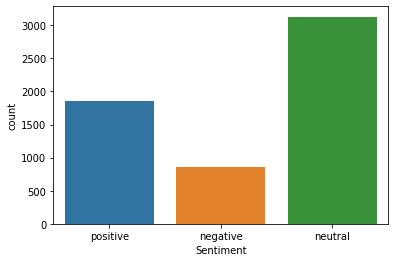

In [ ]:
print(df["Sentiment"].value_counts())
sns.countplot(x="Sentiment",data=df);

**Convert sentiment column to numerical data** 

*   positive == 1
*   negative == -1
*   neutral == 0





In [ ]:
target = []

for i in df["Sentiment"]:
    if i == "positive":
        target.append(1)
    elif i == "neutral":
        target.append(0)
    else:
        target.append(-1)
df["Target"] = target

In [ ]:
df["Target"].value_counts()


 0    3130
 1    1852
-1     860
Name: Target, dtype: int64

In [ ]:
df.shape
df.head()

Sentence Sentiment  Target
0  The GeoSolutions technology will leverage Bene...  positive       1
1  $ESI on lows, down $1.50 to $2.50 BK a real po...  negative      -1
2  For the last quarter of 2010 , Componenta 's n...  positive       1
3  According to the Finnish-Russian Chamber of Co...   neutral       0
4  The Swedish buyout firm has sold its remaining...   neutral       0

**Text cleaning**



1.   Divide the sentence in tokens , and for each token 
2.   Remove punctuations  
3.   Remove stopwords 
4.   Text normalizations with stemming and lemmatization ( Ex : "runs, running, ran" have the root word "run") 
5.   Delete rare words with frequency less less than 3 





In [ ]:
# A stop word is a commonly used word (such as “the”, “a”, “an”, “in”) 
stop_words = set(stopwords.words("english")) 

# replace digits with empty character 
df["Sentence"] = df["Sentence"].str.replace("\d","")
 

In [ ]:
def cleaner(data):
    
    # Tokens
    tokens = word_tokenize(str(data).replace("'", "").lower()) 
    
    # Remove Puncs from tokens 
    without_punc = [w for w in tokens if w.isalpha()]
    
    # Remove Stopwords 
    without_sw = [t for t in without_punc if t not in stop_words]
    
    # Lemmatize
    text_len = [WordNetLemmatizer().lemmatize(t) for t in without_sw]
    # Stem
    text_cleaned = [PorterStemmer().stem(w) for w in text_len]
    
    return " ".join(text_cleaned)

In [ ]:
df["Sentence"] = df["Sentence"].apply(cleaner)
df["Sentence"].head()

0    geosolut technolog leverag benefon gp solut pr...
1                              esi low bk real possibl
2    last quarter componenta net sale doubl eurm eu...
3    accord chamber commerc major construct compani...
4    swedish buyout firm sold remain percent stake ...
Name: Sentence, dtype: object

In [ ]:
rare_words = pd.Series(" ".join(df["Sentence"]).split()).value_counts()
rare_words

eur            1625
compani         916
mn              813
oper            633
sale            607
               ... 
dokumentori       1
mouth             1
hun               1
eco               1
divi              1
Length: 7266, dtype: int64

In [ ]:
rare_words = rare_words[rare_words <= 2]


In [ ]:
df["Sentence"] = df["Sentence"].apply(lambda x: " ".join([i for i in x.split() if i not in rare_words.index]))

**Train Test Split**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

In [ ]:
X = df["Sentence"]
y = df["Target"]




>Split data set to : 
*   75% for training
*   25% for testing 


> Set random_state to 42 ( or any number ) inorder to control the randomness of our trained/tested data and not having different results on each run



> stratification means that the train_test_split method returns training and test subsets that have the same proportions of class labels as the input dataset.

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.25,random_state= 42,stratify=y)

**Count Vectorizer**

transform a sentences into a vector on the basis of the frequency (count) of each word that occurs in the entire text

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer


In [ ]:
vt = CountVectorizer(analyzer="word")
X_train_count = vt.fit_transform(X_train)
X_test_count = vt.transform(X_test)

In [ ]:
print(X_train_count.toarray())
X_train_count
X_train_count.shape

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


(4381, 2746)

In [ ]:
vt = CountVectorizer(analyzer="word")
X_train_count = vt.fit_transform(X_train)
X_test_count = vt.transform(X_test)

**Naive bayes**

**Import libraries**

In [ ]:
from sklearn.naive_bayes import MultinomialNB

Among the 3 variantes of Naive bayes :


1.   Gaussian NB
2.   Multinomial NB
3.   Bernouli NB 

We will go for Multinomial NB as it the most appropriate as we work with occurrence counts



In [ ]:
nb_model = MultinomialNB()
start_time = time.time()
nb_model.fit(X_train_count,y_train)
end_time = time.time()

nb_time_execution = end_time - start_time


In [ ]:
nb_pred = nb_model.predict(X_test_count)
nb_train_pred = nb_model.predict(X_train_count)

In [ ]:
print("X Train")
print(classification_report(y_train,nb_train_pred))

print("X Test")
print(classification_report(y_test,nb_pred))

plt.figure(figsize=(8,8))

X Train
              precision    recall  f1-score   support

          -1       0.56      0.77      0.65       645
           0       0.87      0.81      0.84      2347
           1       0.85      0.79      0.82      1389

    accuracy                           0.80      4381
   macro avg       0.76      0.79      0.77      4381
weighted avg       0.81      0.80      0.80      4381

X Test
              precision    recall  f1-score   support

          -1       0.36      0.48      0.42       215
           0       0.76      0.75      0.75       783
           1       0.72      0.64      0.68       463

    accuracy                           0.67      1461
   macro avg       0.62      0.62      0.62      1461
weighted avg       0.69      0.67      0.68      1461



<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

**Random Forest**

**Import libraries**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


Befor applying the random forest, we use GridSearchCV which is hyperparameter Tuning or cross validation method , inorder to search through the best parameter values from the given set of the grid of parameters

In [ ]:
parameters = {'max_features': ('auto','sqrt'),
             'n_estimators': [50, 10, 150],
             'max_depth': [5, 10, None],
             'min_samples_split': [5, 10, 15],
             'min_samples_leaf': [1, 2, 5, 10],
             'bootstrap': [True, False]}
rf = RandomForestClassifier()

In [ ]:
rf_model_cv = GridSearchCV(rf,parameters,cv = 5,n_jobs = -1)
rf_model_cv.fit(X_train_count,y_train)


The best parameters are : 

In [ ]:
rf_model_cv.best_params_

In [ ]:
start_time = time.time()

rf_tuned = RandomForestClassifier(max_depth = None,
                                 max_features = "auto",
                                 min_samples_split = 15,
                                 n_estimators = 150,
                                 bootstrap= False,
                                 min_samples_leaf= 5).fit(X_train_count,y_train)
end_time = time.time()
rf_time_execution = end_time - start_time


In [ ]:
rf_pred = rf_tuned.predict(X_test_count)
rf_train_pred = rf_tuned.predict(X_train_count)

In [ ]:
print("X Train")
print(classification_report(y_train,rf_train_pred))

print("X Test")
print(classification_report(y_test,rf_pred))

plt.figure(figsize=(8,8))


X Train
              precision    recall  f1-score   support

          -1       0.78      0.18      0.29       645
           0       0.73      0.94      0.82      2347
           1       0.79      0.70      0.75      1389

    accuracy                           0.75      4381
   macro avg       0.77      0.61      0.62      4381
weighted avg       0.76      0.75      0.72      4381

X Test
              precision    recall  f1-score   support

          -1       0.60      0.13      0.21       215
           0       0.68      0.91      0.78       783
           1       0.72      0.58      0.64       463

    accuracy                           0.69      1461
   macro avg       0.67      0.54      0.54      1461
weighted avg       0.68      0.69      0.65      1461



<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

**SVC**

In [ ]:
from sklearn.svm import SVC


Parameters :

> C is a hypermeter which is set before the training model and used to control error

> Gamma is also a hypermeter which is set before the training model and used to give curvature weight of the decision boundary.



> Kernels are group of mathematical functions. The function of a kernel is to require data as input and transform it into the desired form. These functions are : linear, nonlinear, polynomial, radial basis function (RBF), and sigmoid



In [ ]:
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}

In [ ]:
grid = GridSearchCV(SVC(),param_grid,cv = 5,n_jobs = -1)
grid.fit(X_train_count,y_train)

The best parameters are :

In [ ]:
grid.best_estimator_

In [ ]:

start_time = time.time()
svc_model = SVC(C = 10,gamma=0.01,kernel ="sigmoid").fit(X_train_count,y_train)
end_time = time.time()

SVM_time_execution = end_time - start_time



In [ ]:
svc_pred = svc_model.predict(X_test_count)
svc_train_pred = svc_model.predict(X_train_count)

In [ ]:
print("X Train")
print(classification_report(y_train,svc_train_pred))

print("X Test")
print(classification_report(y_test,svc_pred))

plt.figure(figsize=(8,8))


X Train
              precision    recall  f1-score   support

          -1       0.83      0.30      0.44       645
           0       0.76      0.96      0.85      2347
           1       0.89      0.75      0.82      1389

    accuracy                           0.80      4381
   macro avg       0.83      0.67      0.70      4381
weighted avg       0.81      0.80      0.78      4381

X Test
              precision    recall  f1-score   support

          -1       0.41      0.13      0.20       215
           0       0.69      0.89      0.78       783
           1       0.78      0.62      0.69       463

    accuracy                           0.70      1461
   macro avg       0.62      0.55      0.56      1461
weighted avg       0.67      0.70      0.66      1461



<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

**Comparaison**

**1-Time execution**

In [ ]:
df_TE = pd.DataFrame({"MultinomialNB":[nb_time_execution],
                      "Random Forest": [rf_time_execution],
                       "SVC": [SVM_time_execution]})
df_TE

In [ ]:
df_TE.plot(kind="barh",title="Time execution", xticks=[0.01,1]) 

**2- Accuracy**

In [ ]:
pred_df_accuracy = pd.DataFrame({'Data':["Test" , "Train"], "MultinomialNB":[accuracy_score(y_test,nb_pred),accuracy_score(y_train,nb_train_pred)],
                      "Random Forest": [accuracy_score(y_test,rf_pred),accuracy_score(y_train,rf_train_pred)],
                       "SVC": [accuracy_score(y_test,svc_pred),accuracy_score(y_test,svc_pred)]})

pred_df_accuracy.set_index('Data', inplace=True)
pred_df_accuracy

MultinomialNB  Random Forest       SVC
Data                                         
Test        0.673511       0.687201  0.695414
Train       0.797307       0.751198  0.695414

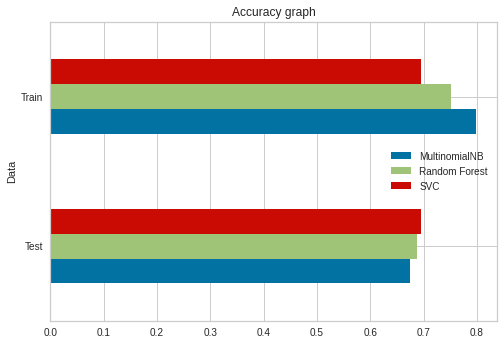

In [ ]:
pred_df_accuracy.plot(kind="barh",title="Accuracy graph" , yticks = [0,1]) 

# Our observation 

Through this data set, we analysed the performance of 3 of most Machine learning models on sentiment analysis. So depending on results :

**1-Time execution**
In terms of time execution, the speed of its convergence is significantly faster than RF or SVM .

**2-Accuracy**
However, when it comes to accuracy , there SVM has realized the best accuracy then it comes RF and at the end we got naive bayes with 0.695, 0.687 and 0.673 respectevily. 

Though, We can see clearly that there is slight differences between  accuracies of the 3 models, which means if we had to consider time execution and accuracy, we can go for naive bayes.

**3-Risk of overfitting**

